In [1]:
import specsuite as ss
import numpy as np
import matplotlib.pyplot as plt

### _Loading Data_
Data taken from KOSMOS is relatively simple to process. It has a single gain value shared across all pixels (stored in metadata as "GAIN") and does not split up its two chips into separate portions of the FITS file. This means we can use the same function calls showed in the preceeding documentation!

In [2]:
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
DATA_REGION = (175, 300)

# Loads standard calibration images
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    instrument = "KOSMOS",
    crop_bds = DATA_REGION,
)
flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat", 
    instrument="KOSMOS",
    crop_bds = DATA_REGION,
)
arc = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    instrument = "KOSMOS",
    crop_bds = DATA_REGION,
)

# Loads target object exposures
science = ss.collect_images_array(
    path = DATA_PATH,
    tag = "toi3884",
    instrument = "KOSMOS",
    crop_bds = DATA_REGION,
).astype(float)

We may also want to take a look at some of these exposures to help us understand some unique complications of using KOSMOS...

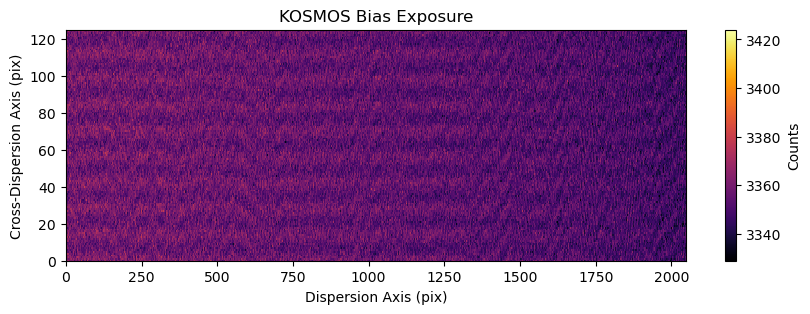

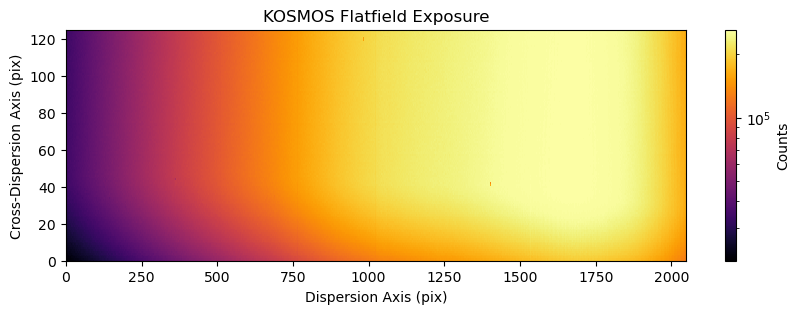

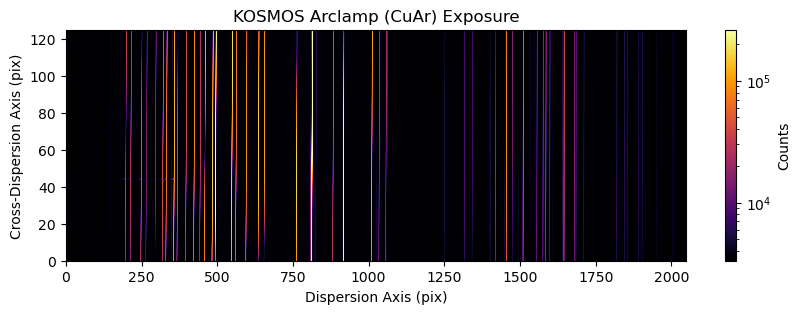

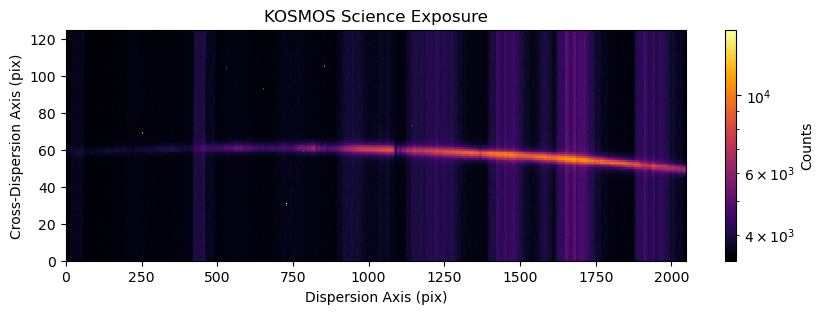

In [3]:
ss.plot_image(
    bias,
    title = "KOSMOS Bias Exposure",
)

ss.plot_image(
    flat,
    norm = 'log',
    title = "KOSMOS Flatfield Exposure",
)

ss.plot_image(
    arc,
    norm = 'log',
    title = "KOSMOS Arclamp (CuAr) Exposure",
)

ss.plot_image(
    science[0],
    norm = 'log',
    title = "KOSMOS Science Exposure",
)

There are two features worth calling out here. Firstly, the bias exposure has a clear geometric pattern shown up across the detector. The APO technical documentation describes this as "herringbone noise" and is completely normal for the instrument, but should be mitigated as much as possible by averaging exposures where appropriate. Secondly, the flatfield (although hard to see) is saturated toward the right end of the detector. We mistakenly forgot to use a neutral density filter (ND5) to reduce the intensity of the internal quart lamp. Due to this inaccuracy, we will not perform a flatfield calibration in this example. However, we highly recommend that you do so in your own reductions!

In [4]:
flat -= bias
arc -= bias
science -= bias

### _Background Extraction_
Next, we will develop a "warp model" that describes how light is curved onto our detector. To do this, you will need an arclamp exposure and a list of pixel locations where you have identified strong line emissions. You can retrieve these line positions using...

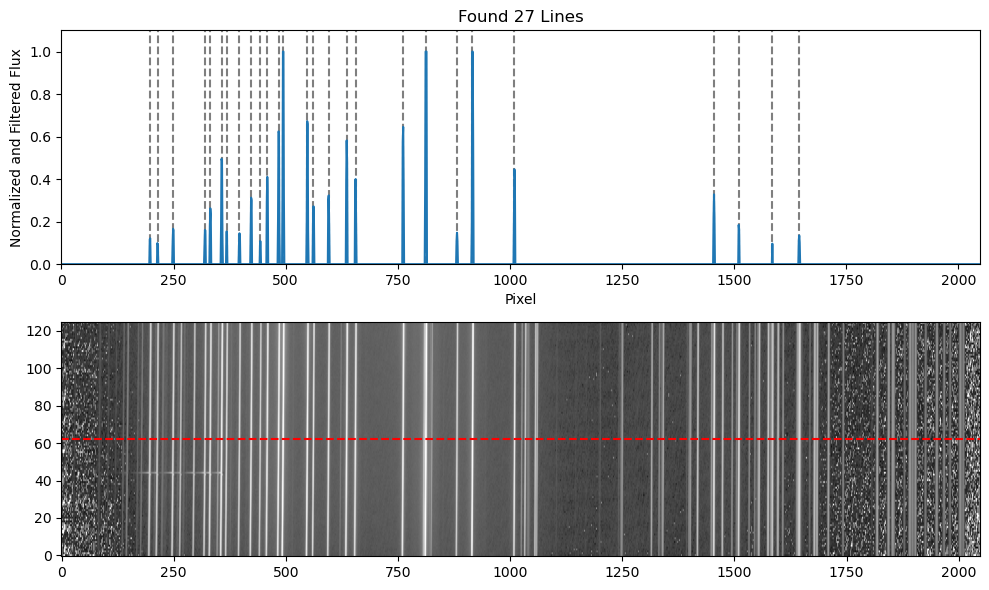

In [5]:
line_locations, rel_intensities = ss.find_cal_lines(
    image = arc,
    std_variation = 250,
    debug = True,
)

In the above plot, you should hopefully see a significant number of well-separated lines. If your threshold is set too low, then you risk accidentally lumping together many nearby features into one effective location.

Once you satisfied with the above line positions, we feed them (along with our arclamp exposure) into...

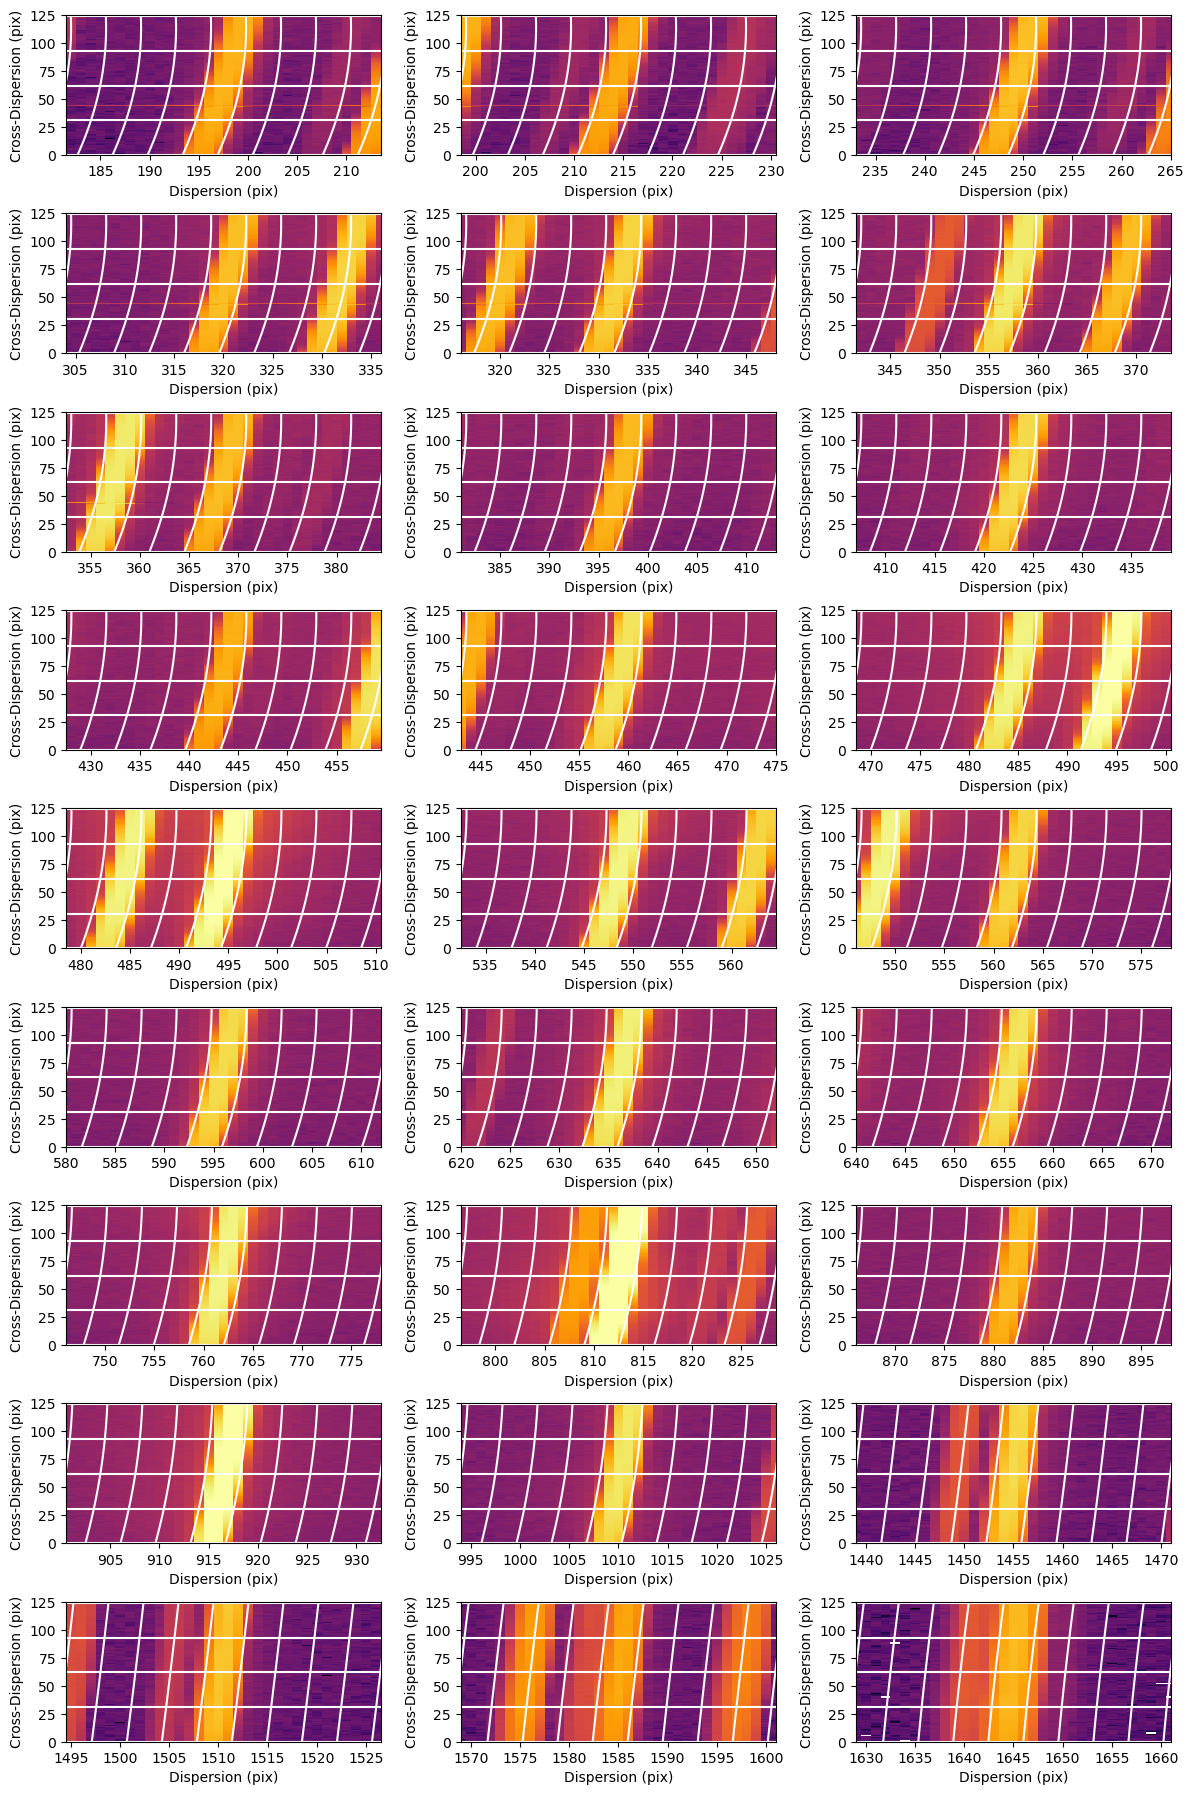

In [6]:
warp_model = ss.generate_warp_model(
    image = arc,
    guess = line_locations,
    debug = True,
)

In this plot, we are checking to make sure that the white grid does a *decent* job of following the shape of lines in that region. We can see how lines in the upper subplots are much more curved than lines in the lower subplots. Since the white grid seems to be accurately tracing out these lines, we can use this "warp model" to extract the background exposures using...

Extracting Background: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


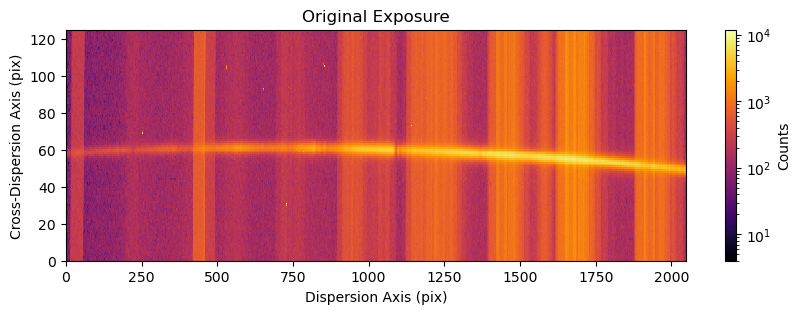

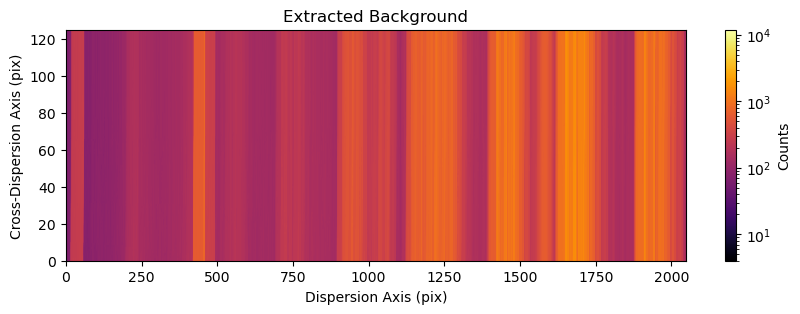

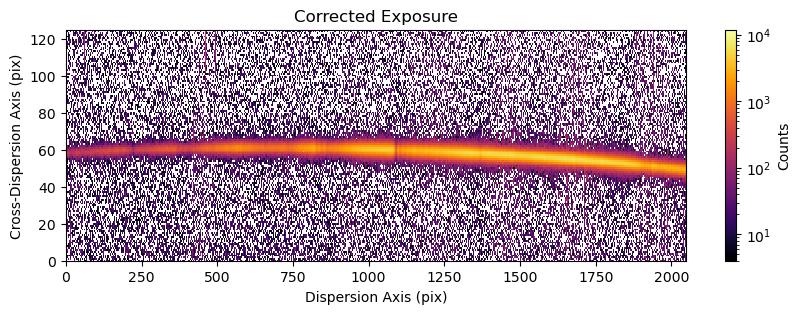

In [7]:
backgrounds = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = (40, 80),
    update = True,
    debug = True,
)

If the warp model is accurate and the extraction was a success, the "corrected exposure" should look like our signal trace with surrounding visual static. This random static is an indication that all geometry in our background exposures have been accurately removed!

### _Flux Extraction_
This thing

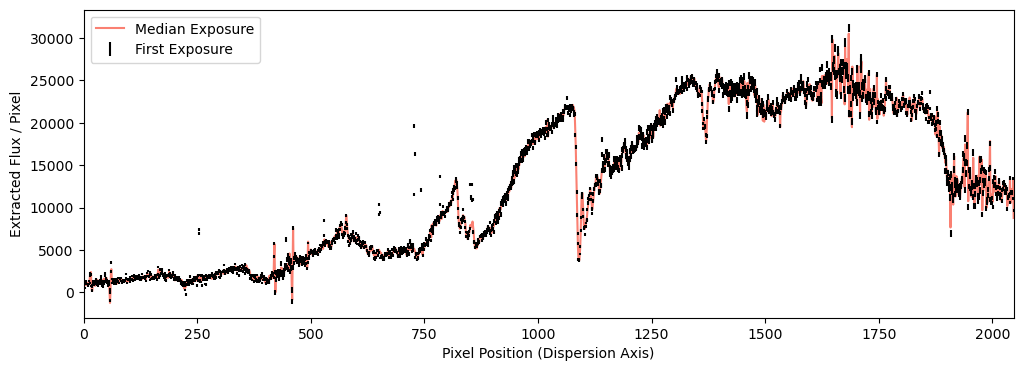

In [8]:
flux, error = ss.boxcar_extraction(
    images = science - backgrounds,
    backgrounds = backgrounds,
    RN = 6.0,
    debug = True,
)

boxcar_flux = np.median(flux, axis=0)
boxcar_error = np.max(error, axis=0)

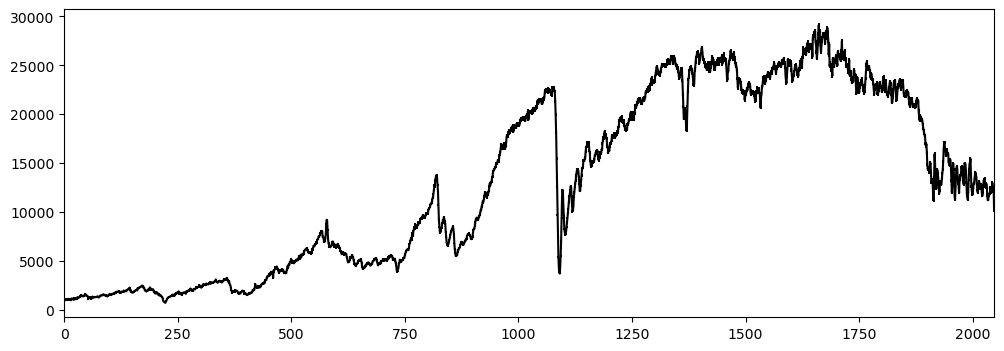

In [9]:
flux, error = ss.horne_extraction(
    images = science - backgrounds,
    backgrounds = backgrounds,
    RN = 6.0,
)

horne_flux = np.median(flux, axis=0)
horne_error = np.max(error, axis=0)

xs = np.array(range(len(horne_flux)))
plt.errorbar(xs, horne_flux, yerr=horne_error, color='k')
plt.xlim(min(xs), max(xs))
#plt.yscale("log")
plt.show()

(2048,) (2048,)


(0.8, 10.0)

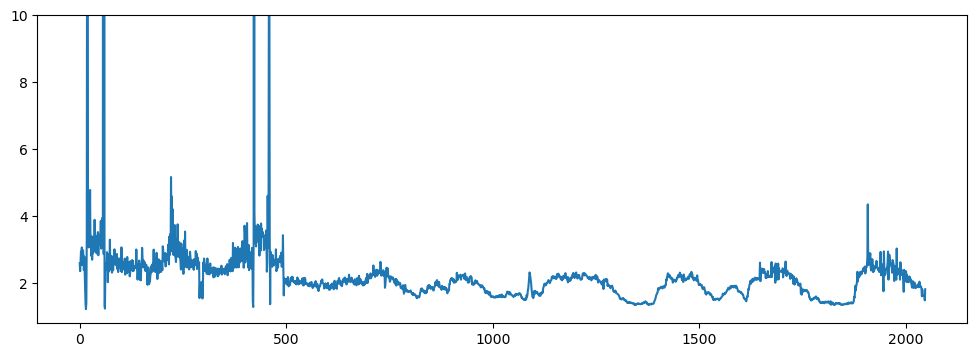

In [10]:
horne_SNR = np.abs(horne_flux/horne_error)
boxcar_SNR = np.abs(boxcar_flux/boxcar_error)

print(horne_SNR.shape, boxcar_SNR.shape)

plt.plot(xs, horne_SNR/boxcar_SNR)
plt.ylim(0.8, 10)

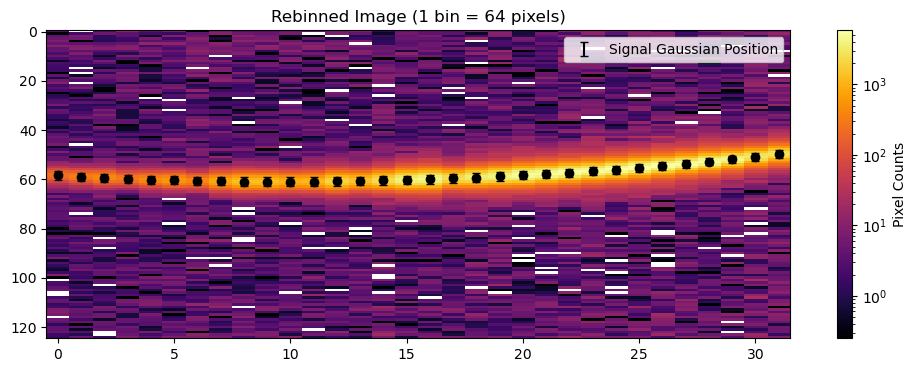

(array([  32.,   96.,  160.,  224.,  288.,  352.,  416.,  480.,  544.,
         608.,  672.,  736.,  800.,  864.,  928.,  992., 1056., 1120.,
        1184., 1248., 1312., 1376., 1440., 1504., 1568., 1632., 1696.,
        1760., 1824., 1888., 1952., 2016.]),
 array([58.42891217, 58.9760106 , 59.41116973, 59.85097851, 60.16275475,
        60.38487801, 60.63375152, 60.78350865, 60.88376405, 60.93387595,
        60.94842546, 60.91649686, 60.79869768, 60.63067868, 60.45672162,
        60.22654029, 59.96645267, 59.6297826 , 59.25490603, 58.84012502,
        58.35383413, 57.87043081, 57.31381191, 56.69416335, 56.04163475,
        55.31603224, 54.54526137, 53.74219189, 52.83807631, 51.92754176,
        50.82850962, 49.7768296 ]),
 array([1.74947782, 1.683712  , 1.68403614, 1.61972376, 1.66389166,
        1.64179008, 1.64177521, 1.70816437, 1.7173839 , 1.70042155,
        1.70434681, 1.73431471, 1.74920718, 1.75905733, 1.75460536,
        1.75642949, 1.75825041, 1.71822955, 1.73263002, 1.719131

In [11]:
ss.trace_fit(science[0] - backgrounds[0], debug=True, bin=2**6)